In [1]:
import os
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from deepface import DeepFace
from torch import nn, optim

# Convert tensor to PIL
to_pil = transforms.ToPILImage()

# Dataset class
class FaceDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []
        self.class_to_idx = {name: i for i, name in enumerate(sorted(os.listdir(root_dir)))}

        for person in os.listdir(root_dir):
            person_dir = os.path.join(root_dir, person)
            if not os.path.isdir(person_dir):
                continue
            label = self.class_to_idx[person]
            for file in os.listdir(person_dir):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(person_dir, file)
                    txt_path = img_path.rsplit('.', 1)[0] + '.txt'
                    if not os.path.exists(txt_path):
                        continue
                    with open(txt_path, 'r') as f:
                        for line in f:
                            parts = line.strip().split()
                            if len(parts) != 5:
                                continue
                            _, x, y, w, h = map(float, parts)
                            self.samples.append((img_path, (x, y, w, h), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, (x, y, w, h), label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        W, H = img.size
        cx, cy, w, h = x * W, y * H, w * W, h * H
        x1 = max(int(cx - w / 2), 0)
        y1 = max(int(cy - h / 2), 0)
        x2 = min(int(cx + w / 2), W)
        y2 = min(int(cy + h / 2), H)
        face = img.crop((x1, y1, x2, y2)).resize((160, 160))
        face_np = np.array(face)

        # DeepFace returns a list of dicts
        embedding = DeepFace.represent(face_np, model_name="Facenet", enforce_detection=False)[0]['embedding']
        return torch.tensor(embedding, dtype=torch.float32), label


class FaceClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FaceClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


# Dataset and dataloader
root = r'C:\Users\anshg\Python_shit\ML\YOLO\user_data'
dataset = FaceDataset(root)


dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Classifier setup
num_classes = len(dataset.class_to_idx)
model = FaceClassifier(input_dim=128, num_classes=num_classes).to('cuda' if torch.cuda.is_available() else 'cpu')
device = next(model.parameters()).device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for embeddings, labels in dataloader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * embeddings.size(0)

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataset):.4f}")



Epoch 1, Loss: 3.4587
Epoch 2, Loss: 2.4486
Epoch 3, Loss: 1.8040
Epoch 4, Loss: 1.3902
Epoch 5, Loss: 1.1447
Epoch 6, Loss: 0.9837
Epoch 7, Loss: 0.8482
Epoch 8, Loss: 0.7828
Epoch 9, Loss: 0.6755
Epoch 10, Loss: 0.6180
Epoch 11, Loss: 0.5725
Epoch 12, Loss: 0.5421
Epoch 13, Loss: 0.5107
Epoch 14, Loss: 0.4783
Epoch 15, Loss: 0.4525
Epoch 16, Loss: 0.4280
Epoch 17, Loss: 0.4090
Epoch 18, Loss: 0.3779
Epoch 19, Loss: 0.3683
Epoch 20, Loss: 0.3458
Epoch 21, Loss: 0.3358
Epoch 22, Loss: 0.3359
Epoch 23, Loss: 0.3184
Epoch 24, Loss: 0.2997
Epoch 25, Loss: 0.2981
Epoch 26, Loss: 0.2879
Epoch 27, Loss: 0.2796
Epoch 28, Loss: 0.2481
Epoch 29, Loss: 0.2449
Epoch 30, Loss: 0.2421
Epoch 31, Loss: 0.2314
Epoch 32, Loss: 0.2166
Epoch 33, Loss: 0.2211
Epoch 34, Loss: 0.2119
Epoch 35, Loss: 0.2057
Epoch 36, Loss: 0.2158
Epoch 37, Loss: 0.1923


In [ ]:
torch.save(model.state_dict(), 'facenet_model.pth')

In [23]:
def visualize_samples_by_class_indices(dataset, selected_indices, samples_per_class=5):
    # idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    classwise_samples = {cls_idx: [] for cls_idx in selected_indices}

    for img_path, bbox, label in dataset.samples:
        if label in selected_indices and len(classwise_samples[label]) < samples_per_class:
            classwise_samples[label].append((img_path, bbox, label))
        if all(len(v) == samples_per_class for v in classwise_samples.values()):
            break

    total = samples_per_class * len(selected_indices)
    plt.figure(figsize=(15, 3 * len(selected_indices)))

    i = 1
    for cls_idx in selected_indices:
        for img_path, (x, y, w, h), label in classwise_samples[cls_idx]:
            img = Image.open(img_path).convert("RGB")
            W, H = img.size
            cx, cy, w, h = x * W, y * H, w * W, h * H
            x1 = max(int(cx - w / 2), 0)
            y1 = max(int(cy - h / 2), 0)
            x2 = min(int(cx + w / 2), W)
            y2 = min(int(cy + h / 2), H)

            plt.subplot(len(selected_indices), samples_per_class, i)
            plt.imshow(img)
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                              edgecolor='red', facecolor='none', linewidth=2))
            plt.title(f'Class {cls_idx}: {idx_to_class[cls_idx]}')
            plt.axis('off')
            i += 1

    plt.tight_layout()
    plt.show()


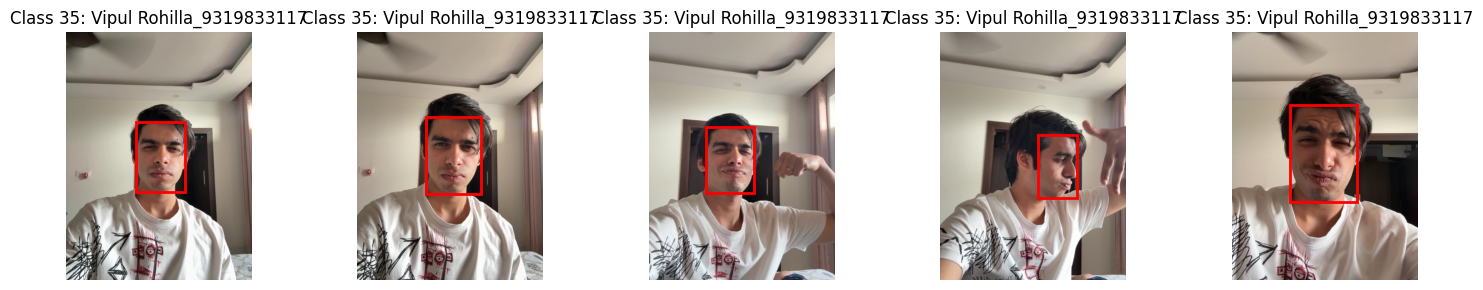

In [26]:
visualize_samples_by_class_indices(dataset, selected_indices=[35], samples_per_class=5)


In [38]:
# Reconstruct class_to_idx and idx_to_class from dataset directory
root_dir = r'C:\Users\anshg\Python_shit\ML\YOLO\user_data'  # Update path if needed
class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for name, i in class_to_idx.items()}


In [39]:
print(idx_to_class)

{0: 'Aabis', 1: 'Aaditya Kumawat_9667275999', 2: 'Abhinav', 3: 'Agrim Verma _96256 39531', 4: 'Ak_7388870397', 5: 'Akshat Sharma _9958276464', 6: 'Amit kumar meena _8527735138', 7: 'Ananta_8133022216', 8: 'Anurag', 9: 'Aryan', 10: 'Ashit', 11: 'Aumkumar Savaliya _9310166959', 12: 'Avaneesh R _9591835700', 13: 'Ayush chandra_9557675828', 14: 'Ayush_patel', 15: 'Berni', 16: 'Cjcjf_13344', 17: 'Dab', 18: 'Deepak', 19: 'Deepanshu_9891367183', 20: 'Dhruv Singh_6397433141', 21: 'Gorang Rathi_8502865687', 22: 'Himanshu', 23: 'Hrishikesh Giri_9126300005', 24: 'Inian Aditya M_8072662632', 25: 'Kalpesh', 26: 'Kartik sharma_9306427609', 27: 'Krish Bansal_9991009776', 28: 'Krishang Goyal_6397372156', 29: 'Maan', 30: 'Milind Soni_6375643332', 31: 'Ojas', 32: 'Pappu', 33: 'Param_9602449849', 34: 'Rahul', 35: 'Raju_7388870397', 36: 'Ram', 37: 'Sanju', 38: 'Satyarth_9236365670', 39: 'Shaurya', 40: 'Siddharth Yadav_8090451478', 41: 'Sonu', 42: 'Sumit Biswal _8847897531', 43: 'Utkarsh Agrawal_7489600646

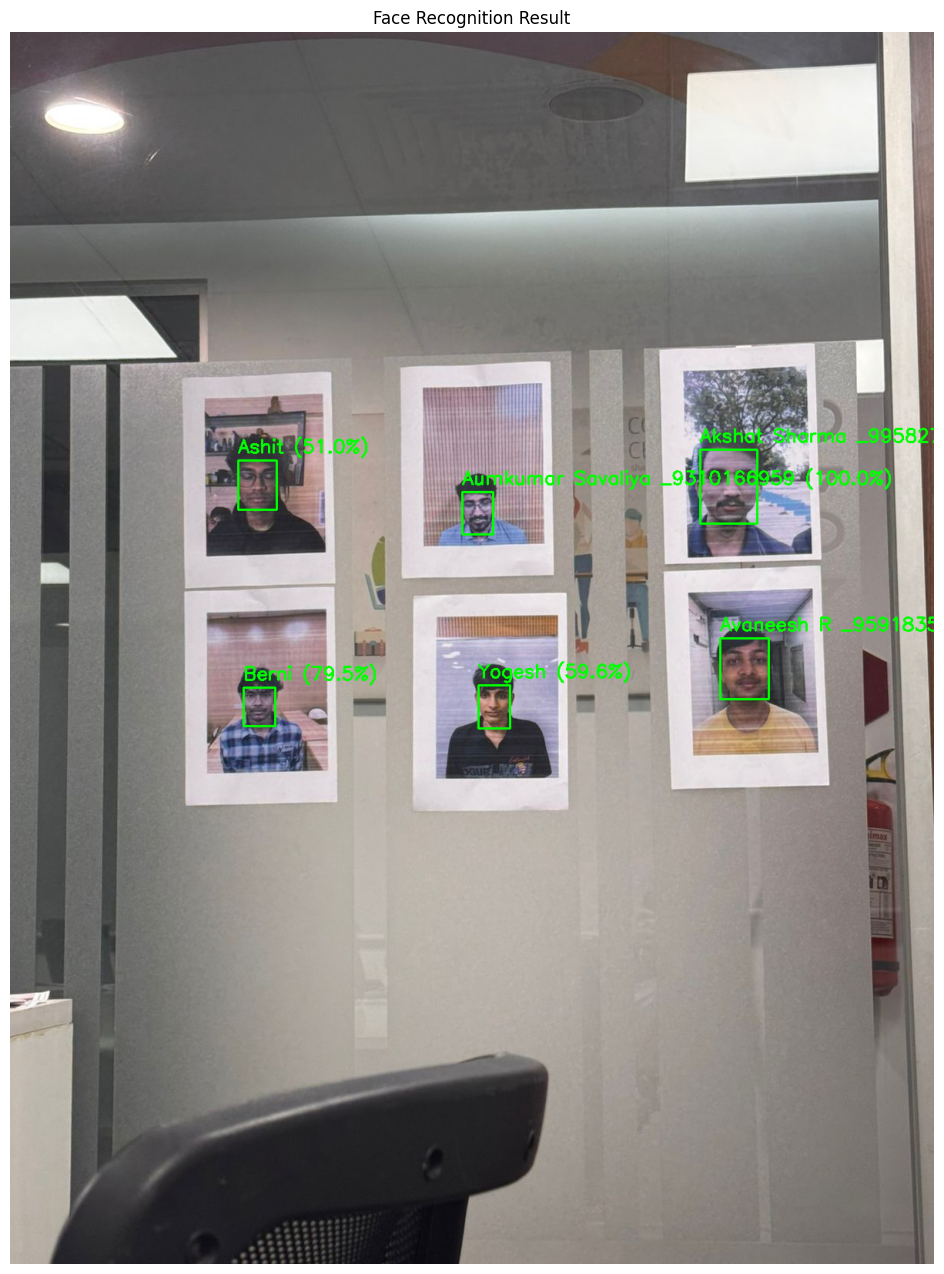

In [ ]:
import cv2
import torch
import os
import numpy as np
from PIL import Image
from deepface import DeepFace
from torchvision import transforms
from ultralytics import YOLO
from torch import nn
import matplotlib.pyplot as plt

# Config
MODEL_PATH_YOLO = "yolov8n_face.pt"
CLASSIFIER_PATH = "facenet_model.pth"
INPUT_IMAGE = "frame_1.jpg"
OUTPUT_IMAGE = "outputs/annotated_frame_1.jpg"
os.makedirs("outputs", exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classifier
class FaceClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FaceClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

num_classes = 50
classifier = FaceClassifier(input_dim=128, num_classes=num_classes).to(device)
classifier.load_state_dict(torch.load(CLASSIFIER_PATH, map_location=device))
classifier.eval()

idx_to_class = {0: 'Aabis', 1: 'Aaditya Kumawat_9667275999', 2: 'Abhinav', 3: 'Agrim Verma _96256 39531', 4: 'Ak_7388870397', 5: 'Akshat Sharma _9958276464', 6: 'Amit kumar meena _8527735138', 7: 'Ananta_8133022216', 8: 'Anurag', 9: 'Aryan', 10: 'Ashit', 11: 'Aumkumar Savaliya _9310166959', 12: 'Avaneesh R _9591835700', 13: 'Ayush chandra_9557675828', 14: 'Ayush_patel', 15: 'Berni', 16: 'Cjcjf_13344', 17: 'Dab', 18: 'Deepak', 19: 'Deepanshu_9891367183', 20: 'Dhruv Singh_6397433141', 21: 'Gorang Rathi_8502865687', 22: 'Himanshu', 23: 'Hrishikesh Giri_9126300005', 24: 'Inian Aditya M_8072662632', 25: 'Kalpesh', 26: 'Kartik sharma_9306427609', 27: 'Krish Bansal_9991009776', 28: 'Krishang Goyal_6397372156', 29: 'Maan', 30: 'Milind Soni_6375643332', 31: 'Ojas', 32: 'Pappu', 33: 'Param_9602449849', 34: 'Rahul', 35: 'Raju_7388870397', 36: 'Ram', 37: 'Sanju', 38: 'Satyarth_9236365670', 39: 'Shaurya', 40: 'Siddharth Yadav_8090451478', 41: 'Sonu', 42: 'Sumit Biswal _8847897531', 43: 'Utkarsh Agrawal_7489600646', 44: 'Vihan Budania _6377544497', 45: 'Vipul Rohilla_9319833117', 46: 'Yogesh', 47: 'Yug _8851291009', 48: 'samar_8736075866', 49: 'yasht_1_1234567890'}

# YOLO face detector
yolo_face = YOLO(MODEL_PATH_YOLO)

# Load and process image
frame = cv2.imread(INPUT_IMAGE)
if frame is None:
    raise FileNotFoundError(f"Image not found: {INPUT_IMAGE}")

results = yolo_face.predict(frame, conf=0.3, iou=0.4, verbose=False)

# Recognition
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        face_crop = frame[y1:y2, x1:x2]
        if face_crop.size == 0:
            continue
        face_pil = Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)).resize((160, 160))
        face_np = np.array(face_pil)
        embedding = DeepFace.represent(face_np, model_name="Facenet", enforce_detection=False)[0]['embedding']
        embedding_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = classifier(embedding_tensor)
            prob = torch.nn.functional.softmax(logits, dim=1)
            pred_idx = prob.argmax(dim=1).item()
            confidence = prob[0][pred_idx].item()
            identity = idx_to_class[pred_idx]

        label = f"{identity} ({confidence*100:.1f}%)"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Save and show with matplotlib
cv2.imwrite(OUTPUT_IMAGE, frame)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 16))
plt.imshow(frame_rgb)
plt.axis("off")
plt.title("Face Recognition Result")
plt.show()


In [7]:
confidence

0.4708726704120636

In [37]:
import os
import cv2
from ultralytics import YOLO

# Load YOLOv8 face model
model = YOLO("yolov8n_face.pt")

def detect_and_annotate_faces(image_path):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    results = model.predict(image_path, conf=0.1, verbose=False)
    largest_box = None
    max_area = 0

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)
            area = (x2 - x1) * (y2 - y1)
            aspect_ratio = (x2 - x1) / (y2 - y1 + 1e-6)

            # Filters
            if area < 0.05 * w * h: continue
            if y2 < 0.3 * h: continue
            if aspect_ratio < 0.75 or aspect_ratio > 1.5: continue

            if area > max_area:
                max_area = area
                largest_box = (x1, y1, x2, y2)

    try: x1, y1, x2, y2 = largest_box
    except: return
    x_center = ((x1 + x2) / 2) / w
    y_center = ((y1 + y2) / 2) / h
    width = (x2 - x1) / w
    height = (y2 - y1) / h

    return [(x_center, y_center, width, height)]

def build_class_map(root_folder):
    subfolders = sorted([d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))])
    return {name: idx for idx, name in enumerate(subfolders)}

def process_user_data(root_folder):
    class_map = build_class_map(root_folder)
    print("Class mapping:", class_map)

    for person_name, class_id in class_map.items():
        person_path = os.path.join(root_folder, person_name)
        for file in os.listdir(person_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(person_path, file)
                txt_path = os.path.splitext(img_path)[0] + '.txt'

                if os.path.exists(txt_path):
                    print(f"Skipping already processed image: {img_path}")
                    continue

                boxes = detect_and_annotate_faces(img_path)
                try:
                    with open(txt_path, 'w') as f:
                        for box in boxes:
                            line = f"{class_id} " + " ".join([str(round(x, 6)) for x in box]) + '\n'
                            f.write(line)
                except:
                    continue
                print(f"Annotated: {img_path}")

# Run
process_user_data("user_data")


Class mapping: {'Aabis': 0, 'Aaditya Kumawat_9667275999': 1, 'Abhinav': 2, 'Agrim Verma _96256 39531': 3, 'Ak_7388870397': 4, 'Akshat Sharma _9958276464': 5, 'Amit kumar meena _8527735138': 6, 'Ananta_8133022216': 7, 'Anurag': 8, 'Aryan': 9, 'Ashit': 10, 'Aumkumar Savaliya _9310166959': 11, 'Avaneesh R _9591835700': 12, 'Ayush chandra_9557675828': 13, 'Ayush_patel': 14, 'Berni': 15, 'Cjcjf_13344': 16, 'Dab': 17, 'Deepak': 18, 'Deepanshu_9891367183': 19, 'Dhruv Singh_6397433141': 20, 'Gorang Rathi_8502865687': 21, 'Himanshu': 22, 'Hrishikesh Giri_9126300005': 23, 'Inian Aditya M_8072662632': 24, 'Kalpesh': 25, 'Kartik sharma_9306427609': 26, 'Krish Bansal_9991009776': 27, 'Krishang Goyal_6397372156': 28, 'Maan': 29, 'Milind Soni_6375643332': 30, 'Ojas': 31, 'Pappu': 32, 'Param_9602449849': 33, 'Rahul': 34, 'Raju_7388870397': 35, 'Ram': 36, 'Sanju': 37, 'Satyarth_9236365670': 38, 'Shaurya': 39, 'Siddharth Yadav_8090451478': 40, 'Sonu': 41, 'Sumit Biswal _8847897531': 42, 'Utkarsh Agrawal